In [ ]:
!pip install torch torchvision
!pip install opencv-python-headless
!pip install albumentations
!pip install nibabel
!pip install matplotlib
!pip install Pillow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.3 MB/s eta 0:00:00


In [ ]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import SimpleITK as sitk
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CriticalFemourSegmentation(Dataset):

    def __init__(self, root, transformations=None):
        im_nrrd_paths = sorted(glob.glob(f"{root}/Images/*.nrrd"))
        gt_nrrd_paths = sorted(glob.glob(f"{root}/GoldStandard/*.nrrd"))

        numeri_lista = []

        for percorso in gt_nrrd_paths:
            # Estrai il numero alla fine del percorso del file vicino alla 'L'
            numero = int(percorso.split('/')[-1].split('_')[0][1:])
            numeri_lista.append(numero)


        indice_da_rimuovere = numeri_lista.index(442)

        # Rimuovi l'elemento corrispondente all'indice trovato da gt_paths
        elemento_da_rimuovere = gt_nrrd_paths[indice_da_rimuovere]
        gt_nrrd_paths.remove(elemento_da_rimuovere)

        self.ims, self.gts, self.slice_indices = self.get_slices(im_nrrd_paths, gt_nrrd_paths)
        self.transformations = transformations
        self.n_cls = 2

        assert len(self.ims) == len(self.gts)

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        im, gt = self.ims[idx], self.gts[idx]
        slice_index = self.slice_indices[idx]
        if self.transformations:
            im, gt = self.apply_transformations(im, gt)

        # For visualization purposes
        im = self.preprocess_im(im)
        # For the cases when label equals to 2; to avoid CE Loss error
        gt[gt > 1] = 1

        return im.float(), gt.unsqueeze(0).long(), slice_index

    def apply_transformations(self, im, gt):
        transformed = self.transformations(image=im, mask=gt)
        return transformed["image"], transformed["mask"]

    def get_slices(self, im_nrrd_paths, gt_nrrd_paths):
        ims, gts, slice_indices = [], [], []

        for index, (im_nrrd, gt_nrrd) in enumerate(zip(im_nrrd_paths, gt_nrrd_paths)):
            print(f"NRRD file number {index + 1} is being converted...")
            nrrd_im_data, nrrd_gt_data = self.read_nrrd(im_nrrd, gt_nrrd)
            # Collect axial slices (axis 0)
            axial_slices = []
            for idx in range(nrrd_im_data.shape[0]):
                im_slice = nrrd_im_data[idx, :, :]
                gt_slice = nrrd_gt_data[idx, :, :]
                if len(np.unique(gt_slice)) == 2 and not np.all(im_slice == 0):
                    axial_slices.append((im_slice, gt_slice, index))

            # Keep only the first 20 and last 20 slices that are not full black
            axial_slices = axial_slices[:20] + axial_slices[-20:]

            for im_slice, gt_slice, slice_index in axial_slices:
                # Resize image and mask to 256x256
                im_resized = sitk.GetArrayFromImage(sitk.Resample(sitk.GetImageFromArray(im_slice), (256, 256)))
                gt_resized = sitk.GetArrayFromImage(sitk.Resample(sitk.GetImageFromArray(gt_slice), (256, 256)))
                ims.append(im_resized)
                gts.append(gt_resized)
                slice_indices.append(slice_index)

        return ims, gts, slice_indices

    def read_nrrd(self, im_path, gt_path):
        im_data = sitk.ReadImage(im_path)
        gt_data = sitk.ReadImage(gt_path)
        return sitk.GetArrayFromImage(im_data), sitk.GetArrayFromImage(gt_data)

    def preprocess_im(self, im):
        # Push background value of -3024 to -1000
        im[im == -3024] = -1000

        # Min-max scaling
        min_val = torch.min(im)
        max_val = torch.max(im)

        # Ensure the min value is not equal to the max value to avoid division by zero
        if min_val != max_val:
            im = (im - min_val) / (max_val - min_val)
        else:
            im = torch.zeros_like(im)

        return im

# Example usage to plot an image before DataLoader creation
def get_dls(root, transformations, bs, split=[0.6, 0.2, 0.2], ns=4):
    ds = CriticalFemourSegmentation(root=root, transformations=transformations)
    n_cls = ds.n_cls

    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)

    ds_len = len(ds)
    indices = list(range(ds_len))

    # Define the lengths for the splits
    tr_len = int(0.6 * ds_len)  # 60% for training
    val_len = int(0.2 * ds_len)  # 20% for validation

    # Split indices
    tr_indices = indices[:tr_len]
    val_indices = indices[tr_len:tr_len + val_len]
    test_indices = indices[tr_len + val_len:]

    # Create subsets
    tr_ds = Subset(ds, tr_indices)
    val_ds = Subset(ds, val_indices)
    test_ds = Subset(ds, test_indices)

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    tr_dl = DataLoader(dataset=tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
    val_dl = DataLoader(dataset=val_ds, batch_size=bs, shuffle=False, num_workers=ns)
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=ns)

    return ds, tr_dl, val_dl, test_dl, n_cls

root = r"/content/drive/MyDrive/Runnare_fusco/NewPatients/NewPatients"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose([
    ToTensorV2(transpose_mask=True),
])
ds, tr_dl, val_dl, test_dl, n_cls = get_dls(root=root, transformations=trans, bs=16)


NRRD file number 1 is being converted...
NRRD file number 2 is being converted...
NRRD file number 3 is being converted...
NRRD file number 4 is being converted...
NRRD file number 5 is being converted...
NRRD file number 6 is being converted...
NRRD file number 7 is being converted...
NRRD file number 8 is being converted...
NRRD file number 9 is being converted...
NRRD file number 10 is being converted...
NRRD file number 11 is being converted...
NRRD file number 12 is being converted...
NRRD file number 13 is being converted...
NRRD file number 14 is being converted...
NRRD file number 15 is being converted...
NRRD file number 16 is being converted...
NRRD file number 17 is being converted...
NRRD file number 18 is being converted...
NRRD file number 19 is being converted...
NRRD file number 20 is being converted...
NRRD file number 21 is being converted...
NRRD file number 22 is being converted...
NRRD file number 23 is being converted...
NRRD file number 24 is being converted...
N

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=c5d2d9a63c9c2cd08ff1e3741ed83ef8486231e2c82bace5253a2c916a4d327a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=36a21238dac8208ce554ca5b48dcffd344d8ad6336c2d5b49dccad15f8a84f52
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


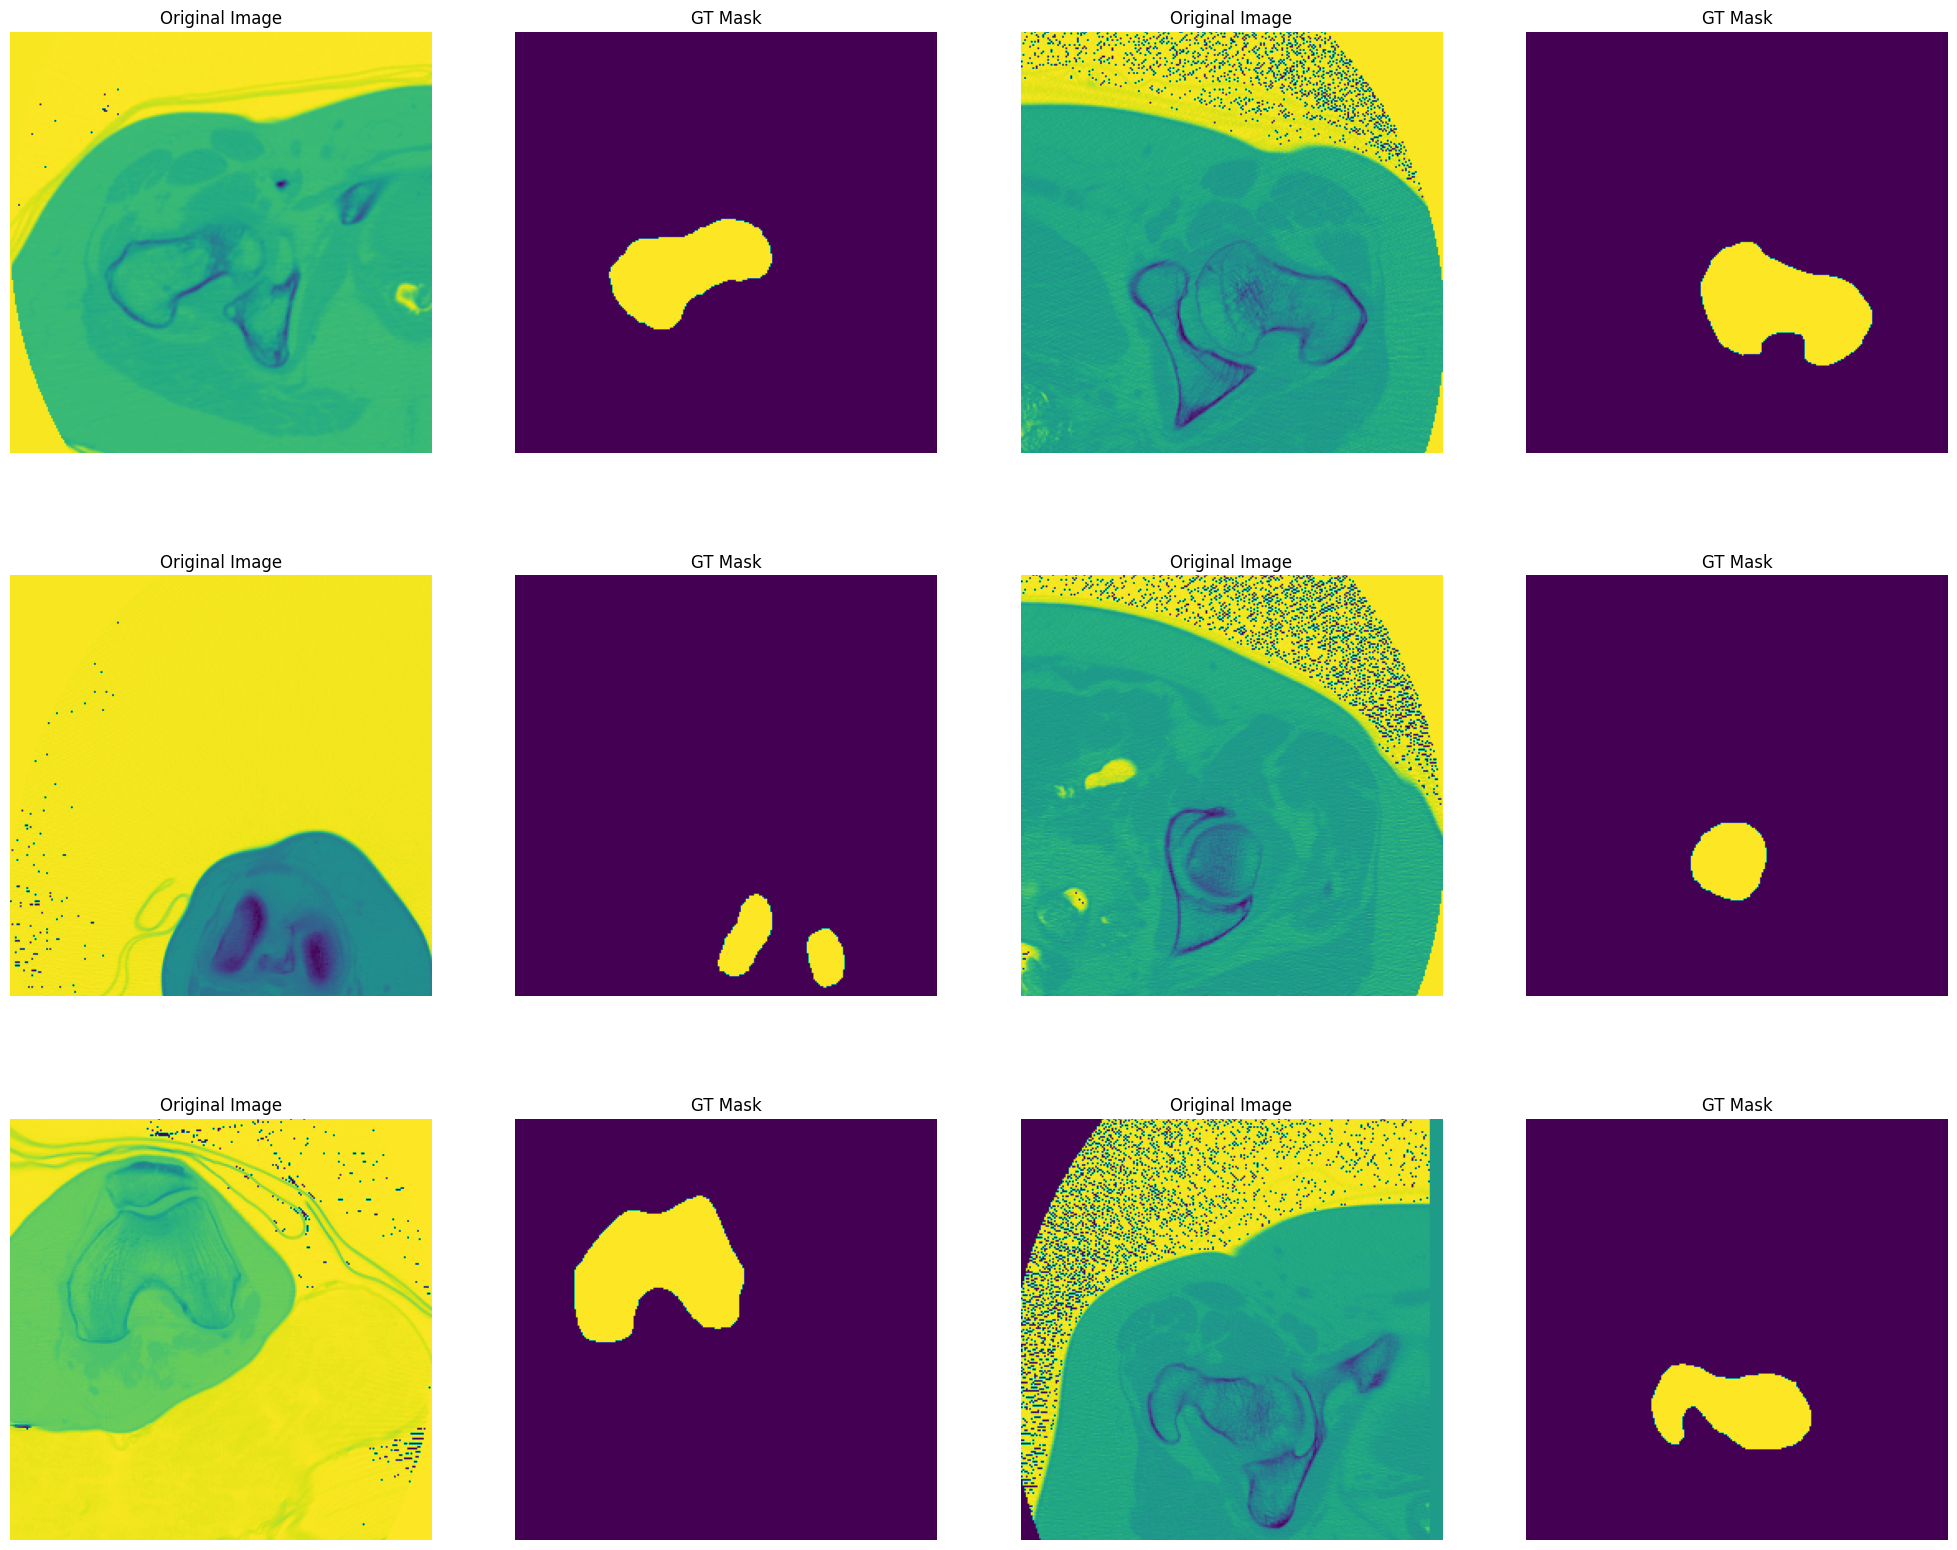

In [ ]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(im.squeeze(0).float()) if gt else plt.imshow((im * 255).cpu().permute(1, 2, 0).numpy().astype("uint8") * 255)
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]

    for idx, index in enumerate(indices):

        if count == n_ims + 1: break

        im, gt,_ = ds[index]

        # First Plot
        count = plot(rows, cols, count, im = im)

        # Second Plot
        count = plot(rows, cols, count, im = gt.squeeze(0), gt = True, title = "GT Mask")

visualize(tr_dl.dataset, n_ims = 12)

In [ ]:
!pip install segmentation_models_pytorch

# Resnet 50

In [ ]:
import segmentation_models_pytorch as smp, time
model= smp.Unet(
    encoder_name='resnet50',
    encoder_weights="imagenet",
    encoder_depth=5,
    in_channels=1,
    classes=n_cls,
    activation=None,
    )

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 117MB/s]


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():

    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):

        self.pred, self.gt = torch.argmax(pred, dim = 1) > 0, gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_, self.device = loss_fn, eps, n_cls, pred, device

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum()) / float(match.numel())

    def mIoU(self):

        with torch.no_grad():

            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []

            for c in range(self.n_cls):

                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)

                else:

                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)

    def loss(self): return self.loss_fn(self.pred_, self.gt.squeeze(1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

In [ ]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs
from tqdm import tqdm

In [ ]:
EPOCHS = 5

In [ ]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, threshold = 0.00, save_path = "saved_models"):

    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok = True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            ims, gts,_ = batch
            ims, gts = ims.to(device), gts.to(device).long()

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss().requires_grad_()

            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts,_ = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

        if best_loss > (val_loss_ + threshold):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = EPOCHS, save_prefix = "UnetResnet50")

Start training process...
Epoch 1 train process is started...


  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 60/60 [00:22<00:00,  2.72it/s]


Epoch 1 validation process is started...


100%|██████████| 20/20 [00:03<00:00,  6.14it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 25.351 secs
Train Loss         -> 0.217
Train PA           -> 0.894
Train IoU          -> 0.797
Validation Loss    -> 0.095
Validation PA      -> 0.961
Validation IoU     -> 0.881

Loss decreased from inf to 0.095!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 2 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 22.528 secs
Train Loss         -> 0.063
Train PA           -> 0.913
Train IoU          -> 0.918
Validation Loss    -> 0.036
Validation PA      -> 0.962
Validation IoU     -> 0.952

Loss decreased from 0.095 to 0.036!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 60/60 [00:19<00:00,  3.06it/s]


Epoch 3 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 22.175 secs
Train Loss         -> 0.037
Train PA           -> 0.913
Train IoU          -> 0.933
Validation Loss    -> 0.031
Validation PA      -> 0.962
Validation IoU     -> 0.946

Loss decreased from 0.036 to 0.031!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 60/60 [00:19<00:00,  3.00it/s]


Epoch 4 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  6.99it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 22.870 secs
Train Loss         -> 0.024
Train PA           -> 0.912
Train IoU          -> 0.954
Validation Loss    -> 0.019
Validation PA      -> 0.962
Validation IoU     -> 0.963

Loss decreased from 0.031 to 0.019!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 60/60 [00:20<00:00,  2.90it/s]


Epoch 5 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  7.52it/s]

Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 23.374 secs
Train Loss         -> 0.019
Train PA           -> 0.912
Train IoU          -> 0.959
Validation Loss    -> 0.035
Validation PA      -> 0.961
Validation IoU     -> 0.930

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Train process is completed in 1.961 minutes.


In [ ]:
class Plot():

    def __init__(self, res):

        self.res = res

        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU",
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")

        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA",
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")

        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss",
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")

    def plot(self, metric, label): plt.plot(self.res[metric], label = label)

    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()

    def visualize(self, metric1, metric2, label1, label2, title, ylabel):

        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)


In [ ]:
def inference(dl, model, device, n_ims = 60):

    cols = n_ims // 3; rows = n_ims // cols

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt,_ = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)

    plt.figure(figsize = (15, 30))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        # First plot
        count = plot(cols, rows, count, im.squeeze(0))

        # Second plot
        count = plot(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

In [ ]:
def print_results(miou_test,dicescores,volume_similarities,vol_sim_abs,execution_time,list_mioU3D,list_dice3D):
  print("The MIOU for the segmentation over the test set resulted in:")
  print(np.round(np.array(miou_test).mean(),3), " +\- ",np.round(np.array(miou_test).std(),3) )
  print()
  print("The MIOU 3D for the segmentation over the test set resulted in:")
  print(np.round(np.array(list_mioU3D).mean(),3), " +\- ",np.round(np.array(list_mioU3D).std(),3) )
  print()
  print("The Dicescore for the segmentation over the test set resulted in:")
  print(np.round(np.array(dicescores).mean(),3), " +\- ", np.round(np.array(dicescores).std(),3))
  print()
  print("The Dicescore 3D for the segmentation over the test set resulted in:")
  print(np.round(np.array(list_dice3D).mean(),3), " +\- ", np.round(np.array(list_dice3D).std(),3))
  print()
  print("The volume similarity for the segmentation over the test set resulted in:")
  print(np.round(np.array(volume_similarities).mean(),3), " +\- ", np.round(np.array(volume_similarities).std(),3))
  print()

  print("The volume similarity abs for the segmentation over the test set resulted in:")
  print(np.round(np.array(vol_sim_abs).mean(),3), " +\- ", np.round(np.array(vol_sim_abs).std(),3))
  print()

  print()
  print("The time needed for the segmentation of 8 3D images is:")
  print(np.round(execution_time,2), "seconds.")



In [ ]:
import time
import numpy as np
import warnings
from tqdm import tqdm  # Import tqdm for progress bar

# Suppress the specific warning about DataLoader workers
warnings.filterwarnings("ignore", category=UserWarning, message=".*DataLoader.*max number of worker.*")
def calculate_volume_similarity(gtMask,predMask):
    gtMask = np.array(gtMask)
    predMask = np.array(predMask)
    tp = np.sum((gtMask == 1) & (predMask == 1))
    fp = np.sum((gtMask == 0) & (predMask == 1))
    fn = np.sum((gtMask == 1) & (predMask == 0))
    numerator = fn - fp
    numerator2 = abs(numerator)
    denominator = 2*tp + fp + fn
    if denominator == 0:
      return 0,0
    volume_similarity = 1 - (numerator/denominator)
    volume_similarityabs = 1 - (numerator2/denominator)
    return volume_similarity, volume_similarityabs

def calculateScores(gtMask, predMask):
    # Convert to NumPy arrays if they aren't already
    gtMask = np.array(gtMask)
    predMask = np.array(predMask)

    # Calculate the true positives (TP), false positives (FP), and false negatives (FN)
    tp = np.sum((gtMask == 1) & (predMask == 1))
    fp = np.sum((gtMask == 0) & (predMask == 1))
    fn = np.sum((gtMask == 1) & (predMask == 0))

    # Calculate IoU
    iou = tp / (tp + fp + fn)

    dice = np.sum(predMask[gtMask==1]) * 2.0 / (np.sum(predMask) + np.sum(gtMask))

    return iou, dice



def calculate_results(model,test_data):

  miou_test = []
  dicescores = []
  start_time = time.time()
  min_iou = 0
  current_images = []
  current_gt = []
  index = -1
  volume_similarities = []
  volume_similarity_abs = []
  list_mioU3D = []
  list_dice3D = []

  for idx, data in enumerate(tqdm(test_data)):
      im, gt, images_indexes = data

      if index != images_indexes:
        if index != -1:  # Ensure it's not the first iteration
            vol_sim , vol_sim_abs = calculate_volume_similarity(current_gt, current_images)
            volume_similarities.append(vol_sim)
            volume_similarity_abs.append(vol_sim_abs)
            miou3D, dice3D = calculateScores(current_gt,current_images)
            list_mioU3D.append(miou3D)
            list_dice3D.append(dice3D)
        index = images_indexes
        current_images = []
        current_gt = []



      # Get predicted mask
      with torch.no_grad():
          pred = torch.argmax(model(im.to(device)), dim=1)

      pred = np.array(pred.squeeze(0).cpu())  # Remove batch dimension
      gt = np.array(gt.squeeze(0).cpu()[0])

      Iou, dice = calculateScores(gt, pred)

      current_images.append(pred)
      current_gt.append(gt)

      miou_test.append(Iou)
      dicescores.append(dice)

  if current_gt and current_images:
          vol_sim , vol_sim_abs = calculate_volume_similarity(current_gt, current_images)
          volume_similarities.append(vol_sim)
          volume_similarity_abs.append(vol_sim_abs)
          miou3D, dice3D = calculateScores(current_gt,current_images)
          list_mioU3D.append(miou3D)
          list_dice3D.append(dice3D)
  end_time = time.time()  # End the timer

  execution_time = end_time - start_time
  return volume_similarities,volume_similarity_abs, miou_test, dicescores, execution_time, list_mioU3D,list_dice3D


In [ ]:
volume_similarities,vol_sim_abs, miou_test, dicescores, execution_time, list_mioU3D,list_dice3D = calculate_results(model,test_dl )

print_results(miou_test,dicescores,volume_similarities,vol_sim_abs,execution_time,list_mioU3D,list_dice3D)

100%|██████████| 320/320 [00:08<00:00, 37.39it/s]


The MIOU for the segmentation over the test set resulted in:
0.923  +\-  0.078

The MIOU 3D for the segmentation over the test set resulted in:
0.939  +\-  0.015

The Dicescore for the segmentation over the test set resulted in:
0.958  +\-  0.058

The Dicescore 3D for the segmentation over the test set resulted in:
0.968  +\-  0.008

The volume similarity for the segmentation over the test set resulted in:
1.016  +\-  0.014

The volume similarity abs for the segmentation over the test set resulted in:
0.982  +\-  0.01


The time needed for the segmentation of 8 3D images is:
8.62 seconds.


# Resnet 34

In [ ]:
import segmentation_models_pytorch as smp, time
model= smp.Unet(
    encoder_name='resnet34',
    encoder_weights="imagenet",
    encoder_depth=5,
    in_channels=1,
    classes=n_cls,
    activation=None,
    )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 244MB/s]


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)


In [ ]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs
from tqdm import tqdm

In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = EPOCHS, save_prefix = "UnetResnet34")

Start training process...
Epoch 1 train process is started...


  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


Epoch 1 validation process is started...


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 15.263 secs
Train Loss         -> 0.396
Train PA           -> 0.843
Train IoU          -> 0.697
Validation Loss    -> 0.205
Validation PA      -> 0.958
Validation IoU     -> 0.864

Loss decreased from inf to 0.205!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


Epoch 2 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 15.178 secs
Train Loss         -> 0.120
Train PA           -> 0.914
Train IoU          -> 0.897
Validation Loss    -> 0.082
Validation PA      -> 0.962
Validation IoU     -> 0.914

Loss decreased from 0.205 to 0.082!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


Epoch 3 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 15.421 secs
Train Loss         -> 0.061
Train PA           -> 0.913
Train IoU          -> 0.929
Validation Loss    -> 0.048
Validation PA      -> 0.962
Validation IoU     -> 0.934

Loss decreased from 0.082 to 0.048!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Epoch 4 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 14.864 secs
Train Loss         -> 0.038
Train PA           -> 0.912
Train IoU          -> 0.944
Validation Loss    -> 0.030
Validation PA      -> 0.962
Validation IoU     -> 0.956

Loss decreased from 0.048 to 0.030!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Epoch 5 validation process is started...


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 14.927 secs
Train Loss         -> 0.027
Train PA           -> 0.912
Train IoU          -> 0.956
Validation Loss    -> 0.030
Validation PA      -> 0.962
Validation IoU     -> 0.936

Loss decreased from 0.030 to 0.030!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Train process is completed in 1.274 minutes.


In [ ]:
# model = torch.load("saved_models/liver_best_model.pt")
# inference(test_dl, model = model, device = device)

In [ ]:
volume_similarities,vol_sim_abs, miou_test, dicescores, execution_time, list_mioU3D,list_dice3D = calculate_results(model,test_dl )

print_results(miou_test,dicescores,volume_similarities,vol_sim_abs,execution_time,list_mioU3D,list_dice3D)

100%|██████████| 320/320 [00:05<00:00, 57.41it/s]


The MIOU for the segmentation over the test set resulted in:
0.903  +\-  0.113

The MIOU 3D for the segmentation over the test set resulted in:
0.926  +\-  0.022

The Dicescore for the segmentation over the test set resulted in:
0.944  +\-  0.095

The Dicescore 3D for the segmentation over the test set resulted in:
0.961  +\-  0.012

The volume similarity for the segmentation over the test set resulted in:
0.989  +\-  0.014

The volume similarity abs for the segmentation over the test set resulted in:
0.985  +\-  0.009


The time needed for the segmentation of 8 3D images is:
5.65 seconds.


#Resnet50 Unet++

In [ ]:
import segmentation_models_pytorch as smp, time
import segmentation_models_pytorch as smp, time
model = smp.UnetPlusPlus(
    encoder_name='resnet50',
    encoder_depth=5,
    encoder_weights="imagenet",
    in_channels=1,
    classes=n_cls,
    activation=None,
    )



In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)


In [ ]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs
from tqdm import tqdm

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = EPOCHS, save_prefix = "UnetppResnet50")

Start training process...
Epoch 1 train process is started...


100%|██████████| 60/60 [00:55<00:00,  1.08it/s]


Epoch 1 validation process is started...


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 62.366 secs
Train Loss         -> 0.103
Train PA           -> 0.912
Train IoU          -> 0.852
Validation Loss    -> 0.041
Validation PA      -> 0.962
Validation IoU     -> 0.932

Loss decreased from inf to 0.041!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 60/60 [00:55<00:00,  1.09it/s]


Epoch 2 validation process is started...


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 61.916 secs
Train Loss         -> 0.032
Train PA           -> 0.913
Train IoU          -> 0.931
Validation Loss    -> 0.022
Validation PA      -> 0.963
Validation IoU     -> 0.961

Loss decreased from 0.041 to 0.022!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 60/60 [00:54<00:00,  1.09it/s]


Epoch 3 validation process is started...


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 61.642 secs
Train Loss         -> 0.018
Train PA           -> 0.913
Train IoU          -> 0.957
Validation Loss    -> 0.013
Validation PA      -> 0.962
Validation IoU     -> 0.969

Loss decreased from 0.022 to 0.013!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 60/60 [00:55<00:00,  1.08it/s]


Epoch 4 validation process is started...


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 62.102 secs
Train Loss         -> 0.014
Train PA           -> 0.912
Train IoU          -> 0.964
Validation Loss    -> 0.013
Validation PA      -> 0.962
Validation IoU     -> 0.965

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 60/60 [00:54<00:00,  1.09it/s]


Epoch 5 validation process is started...


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]

Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 61.814 secs
Train Loss         -> 0.017
Train PA           -> 0.912
Train IoU          -> 0.952
Validation Loss    -> 0.018
Validation PA      -> 0.962
Validation IoU     -> 0.957

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Train process is completed in 5.181 minutes.


In [ ]:
# model = torch.load("saved_models/liver_best_model.pt")
# inference(test_dl, model = model, device = device)

In [ ]:
volume_similarities,vol_sim_abs, miou_test, dicescores, execution_time, list_mioU3D,list_dice3D = calculate_results(model,test_dl )

print_results(miou_test,dicescores,volume_similarities,vol_sim_abs,execution_time,list_mioU3D,list_dice3D)

100%|██████████| 320/320 [00:12<00:00, 26.23it/s]

The MIOU for the segmentation over the test set resulted in:
0.901  +\-  0.11

The MIOU 3D for the segmentation over the test set resulted in:
0.927  +\-  0.019

The Dicescore for the segmentation over the test set resulted in:
0.943  +\-  0.081

The Dicescore 3D for the segmentation over the test set resulted in:
0.962  +\-  0.011

The volume similarity for the segmentation over the test set resulted in:
1.011  +\-  0.014

The volume similarity abs for the segmentation over the test set resulted in:
0.985  +\-  0.01


The time needed for the segmentation of 8 3D images is:
12.28 seconds.


#Resnet34 Unet++

In [ ]:
import segmentation_models_pytorch as smp, time
import segmentation_models_pytorch as smp, time
model = smp.UnetPlusPlus(
    encoder_name='resnet34',
    encoder_depth=5,
    encoder_weights="imagenet",
    in_channels=1,
    classes=n_cls,
    activation=None,
    )



In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)


In [ ]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs
from tqdm import tqdm

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = EPOCHS, save_prefix = "UnetppResnet34")

Start training process...
Epoch 1 train process is started...


100%|██████████| 60/60 [00:26<00:00,  2.28it/s]


Epoch 1 validation process is started...


100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 29.911 secs
Train Loss         -> 0.227
Train PA           -> 0.888
Train IoU          -> 0.822
Validation Loss    -> 0.088
Validation PA      -> 0.962
Validation IoU     -> 0.939

Loss decreased from inf to 0.088!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 60/60 [00:26<00:00,  2.27it/s]


Epoch 2 validation process is started...


100%|██████████| 20/20 [00:03<00:00,  5.63it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 29.993 secs
Train Loss         -> 0.067
Train PA           -> 0.914
Train IoU          -> 0.921
Validation Loss    -> 0.041
Validation PA      -> 0.962
Validation IoU     -> 0.959

Loss decreased from 0.088 to 0.041!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 60/60 [00:26<00:00,  2.29it/s]


Epoch 3 validation process is started...


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 29.668 secs
Train Loss         -> 0.037
Train PA           -> 0.913
Train IoU          -> 0.946
Validation Loss    -> 0.047
Validation PA      -> 0.962
Validation IoU     -> 0.896

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 60/60 [00:26<00:00,  2.30it/s]


Epoch 4 validation process is started...


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 29.468 secs
Train Loss         -> 0.025
Train PA           -> 0.912
Train IoU          -> 0.959
Validation Loss    -> 0.024
Validation PA      -> 0.963
Validation IoU     -> 0.952

Loss decreased from 0.047 to 0.024!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 60/60 [00:26<00:00,  2.29it/s]


Epoch 5 validation process is started...


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]

Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 29.715 secs
Train Loss         -> 0.018
Train PA           -> 0.913
Train IoU          -> 0.967
Validation Loss    -> 0.017
Validation PA      -> 0.962
Validation IoU     -> 0.963

Loss decreased from 0.024 to 0.017!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Train process is completed in 2.489 minutes.


In [ ]:
# model = torch.load("saved_models/liver_best_model.pt")


In [ ]:
volume_similarities,vol_sim_abs, miou_test, dicescores, execution_time, list_mioU3D,list_dice3D = calculate_results(model,test_dl )

print_results(miou_test,dicescores,volume_similarities,vol_sim_abs,execution_time,list_mioU3D,list_dice3D)

100%|██████████| 320/320 [00:06<00:00, 48.54it/s]


The MIOU for the segmentation over the test set resulted in:
0.927  +\-  0.075

The MIOU 3D for the segmentation over the test set resulted in:
0.942  +\-  0.012

The Dicescore for the segmentation over the test set resulted in:
0.96  +\-  0.055

The Dicescore 3D for the segmentation over the test set resulted in:
0.97  +\-  0.006

The volume similarity for the segmentation over the test set resulted in:
1.009  +\-  0.015

The volume similarity abs for the segmentation over the test set resulted in:
0.987  +\-  0.011


The time needed for the segmentation of 8 3D images is:
6.66 seconds.


# Unet mobile

In [ ]:
import segmentation_models_pytorch as smp, time
model= smp.Unet(
    encoder_name='timm-mobilenetv3_large_100',
    encoder_depth=5,
    encoder_weights="imagenet",
    in_channels=1,
    classes=n_cls,
    activation=None,
    )


# Assuming you want to load the best model saved during training
  # Make sure this matches the save_path used during training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the best model
# best_model_path = f"/content/drive/MyDrive/saved_models/UnetMobile_best_model.pt"
# model = torch.load(best_model_path, map_location=torch.device(device))


# Make sure to put the model in evaluation mode



Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth
100%|██████████| 21.1M/21.1M [00:01<00:00, 17.3MB/s]


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)


In [ ]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs
from tqdm import tqdm

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = EPOCHS, save_prefix = "UnetMobile")

Start training process...
Epoch 1 train process is started...


100%|██████████| 60/60 [00:10<00:00,  5.56it/s]


Epoch 1 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 13.078 secs
Train Loss         -> 0.502
Train PA           -> 0.745
Train IoU          -> 0.573
Validation Loss    -> 0.156
Validation PA      -> 0.960
Validation IoU     -> 0.905

Loss decreased from inf to 0.156!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 60/60 [00:10<00:00,  5.68it/s]


Epoch 2 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 12.784 secs
Train Loss         -> 0.121
Train PA           -> 0.915
Train IoU          -> 0.905
Validation Loss    -> 0.070
Validation PA      -> 0.962
Validation IoU     -> 0.944

Loss decreased from 0.156 to 0.070!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 60/60 [00:10<00:00,  5.60it/s]


Epoch 3 validation process is started...


100%|██████████| 20/20 [00:01<00:00, 12.50it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 12.331 secs
Train Loss         -> 0.064
Train PA           -> 0.914
Train IoU          -> 0.927
Validation Loss    -> 0.044
Validation PA      -> 0.962
Validation IoU     -> 0.942

Loss decreased from 0.070 to 0.044!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 60/60 [00:10<00:00,  5.68it/s]


Epoch 4 validation process is started...


100%|██████████| 20/20 [00:01<00:00, 12.55it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 12.183 secs
Train Loss         -> 0.041
Train PA           -> 0.913
Train IoU          -> 0.945
Validation Loss    -> 0.031
Validation PA      -> 0.962
Validation IoU     -> 0.953

Loss decreased from 0.044 to 0.031!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 60/60 [00:10<00:00,  5.69it/s]


Epoch 5 validation process is started...


100%|██████████| 20/20 [00:01<00:00, 12.09it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 12.214 secs
Train Loss         -> 0.027
Train PA           -> 0.912
Train IoU          -> 0.960
Validation Loss    -> 0.027
Validation PA      -> 0.962
Validation IoU     -> 0.947

Loss decreased from 0.031 to 0.027!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Train process is completed in 1.050 minutes.


In [ ]:
# model = torch.load("saved_models/liver_best_model.pt")
# inference(test_dl, model = model, device = device)

In [ ]:
volume_similarities,vol_sim_abs, miou_test, dicescores, execution_time, list_mioU3D,list_dice3D = calculate_results(model,test_dl )

print_results(miou_test,dicescores,volume_similarities,vol_sim_abs,execution_time,list_mioU3D,list_dice3D)

100%|██████████| 320/320 [00:06<00:00, 46.10it/s]


The MIOU for the segmentation over the test set resulted in:
0.896  +\-  0.136

The MIOU 3D for the segmentation over the test set resulted in:
0.927  +\-  0.014

The Dicescore for the segmentation over the test set resulted in:
0.937  +\-  0.121

The Dicescore 3D for the segmentation over the test set resulted in:
0.962  +\-  0.008

The volume similarity for the segmentation over the test set resulted in:
0.987  +\-  0.015

The volume similarity abs for the segmentation over the test set resulted in:
0.984  +\-  0.012


The time needed for the segmentation of 8 3D images is:
7.01 seconds.


# Unet++ mobile

In [ ]:
import segmentation_models_pytorch as smp, time
model= smp.UnetPlusPlus(
    encoder_name='timm-mobilenetv3_large_100',
    encoder_depth=5,
    encoder_weights="imagenet",
    in_channels=1,
    classes=n_cls,
    activation=None,
    )

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)


In [ ]:
import json, os, torch, cv2, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob;
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2; from PIL import Image
from torchvision import transforms as tfs
from tqdm import tqdm

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = EPOCHS, save_prefix = "UnetppMobile")

Start training process...
Epoch 1 train process is started...


100%|██████████| 60/60 [00:14<00:00,  4.12it/s]


Epoch 1 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 16.598 secs
Train Loss         -> 0.347
Train PA           -> 0.844
Train IoU          -> 0.677
Validation Loss    -> 0.115
Validation PA      -> 0.961
Validation IoU     -> 0.887

Loss decreased from inf to 0.115!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 60/60 [00:14<00:00,  4.09it/s]


Epoch 2 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 16.783 secs
Train Loss         -> 0.080
Train PA           -> 0.914
Train IoU          -> 0.910
Validation Loss    -> 0.055
Validation PA      -> 0.961
Validation IoU     -> 0.902

Loss decreased from 0.115 to 0.055!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]


Epoch 3 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 17.126 secs
Train Loss         -> 0.044
Train PA           -> 0.914
Train IoU          -> 0.932
Validation Loss    -> 0.030
Validation PA      -> 0.961
Validation IoU     -> 0.952

Loss decreased from 0.055 to 0.030!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Epoch 4 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 17.016 secs
Train Loss         -> 0.031
Train PA           -> 0.913
Train IoU          -> 0.946
Validation Loss    -> 0.023
Validation PA      -> 0.962
Validation IoU     -> 0.954

Loss decreased from 0.030 to 0.023!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 60/60 [00:14<00:00,  4.07it/s]


Epoch 5 validation process is started...


100%|██████████| 20/20 [00:02<00:00,  8.16it/s]

Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 17.209 secs
Train Loss         -> 0.024
Train PA           -> 0.913
Train IoU          -> 0.954
Validation Loss    -> 0.021
Validation PA      -> 0.962
Validation IoU     -> 0.953

Loss decreased from 0.023 to 0.021!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Train process is completed in 1.421 minutes.


In [ ]:
# model = torch.load("saved_models/liver_best_model.pt")
# inference(test_dl, model = model, device = device)

In [ ]:
volume_similarities,vol_sim_abs, miou_test, dicescores, execution_time, list_mioU3D,list_dice3D = calculate_results(model,test_dl )

print_results(miou_test,dicescores,volume_similarities,vol_sim_abs,execution_time,list_mioU3D,list_dice3D)

100%|██████████| 320/320 [00:08<00:00, 36.41it/s]


The MIOU for the segmentation over the test set resulted in:
0.908  +\-  0.12

The MIOU 3D for the segmentation over the test set resulted in:
0.935  +\-  0.014

The Dicescore for the segmentation over the test set resulted in:
0.945  +\-  0.105

The Dicescore 3D for the segmentation over the test set resulted in:
0.966  +\-  0.007

The volume similarity for the segmentation over the test set resulted in:
0.995  +\-  0.016

The volume similarity abs for the segmentation over the test set resulted in:
0.987  +\-  0.01


The time needed for the segmentation of 8 3D images is:
8.86 seconds.
